In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from timm import create_model

In [3]:
from fastai.vision.all import *

In [4]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8

In [5]:
dataset_path = Path('../datasets/kaggle/petfinder/')
dataset_path.ls()

(#13) [Path('../datasets/kaggle/petfinder/train_5folds.csv'),Path('../datasets/kaggle/petfinder/train_10folds.csv'),Path('../datasets/kaggle/petfinder/test.csv'),Path('../datasets/kaggle/petfinder/train.csv'),Path('../datasets/kaggle/petfinder/test'),Path('../datasets/kaggle/petfinder/sample_submission.csv'),Path('../datasets/kaggle/petfinder/archive.zip'),Path('../datasets/kaggle/petfinder/.ipynb_checkpoints'),Path('../datasets/kaggle/petfinder/train'),Path('../datasets/kaggle/petfinder/crop')...]

In [6]:
train_df = pd.read_csv(dataset_path/'mytrain.csv')
train_df.head()

,Unnamed: 0,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,is_cat
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,1
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0


In [7]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Unnamed: 0,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,is_cat,path
0,9122,0,0,1,1,0,0,0,0,0,0,0,1,50,0,../datasets/kaggle/petfinder/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,1469,0,1,1,1,0,1,0,1,0,0,1,0,25,0,../datasets/kaggle/petfinder/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,3970,0,0,1,1,0,1,0,0,0,0,0,0,27,0,../datasets/kaggle/petfinder/train/6548166fb3fda22b67881176397f0223.jpg
3,2760,0,1,1,1,0,0,0,0,1,1,0,0,19,0,../datasets/kaggle/petfinder/train/472c40116e1833555715e4774445ae5b.jpg
4,4798,0,1,1,1,0,0,0,1,0,0,0,0,27,0,../datasets/kaggle/petfinder/train/7b77e1a6d93667b575d57db83facd860.jpg


In [8]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


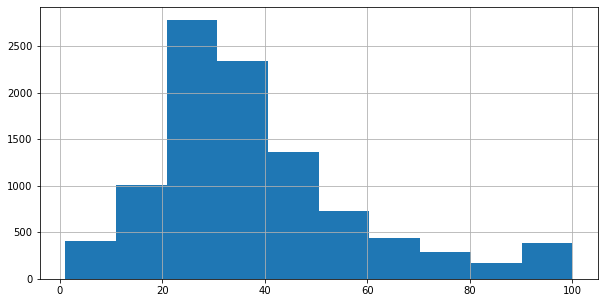

In [9]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [10]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

In [11]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [12]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins

<AxesSubplot:>

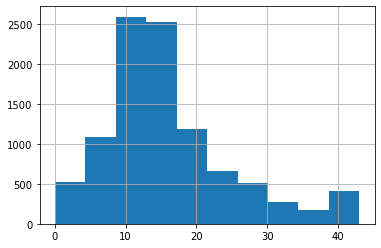

In [13]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

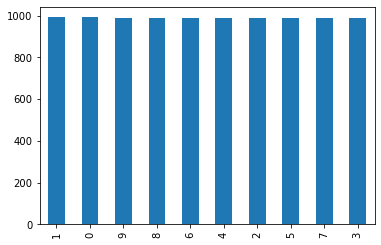

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [15]:
from sklearn.metrics import accuracy_score

def petfinder_focus(input, target, focus, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 1]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, focus.cpu().numpy())

def petfinder_eyes(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 1]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, eyes.cpu().numpy())

def petfinder_face(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 2]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, face.cpu().numpy())

def petfinder_near(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 3]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, near.cpu().numpy())

def petfinder_action(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 4]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, action.cpu().numpy())

def petfinder_accessory(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 5]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, accessory.cpu().numpy())

def petfinder_group(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 6]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, group.cpu().numpy())

def petfinder_collage(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 7]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, collage.cpu().numpy())

def petfinder_human(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 8]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, human.cpu().numpy())

def petfinder_occlusion(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 9]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, occlusion.cpu().numpy())

def petfinder_info(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 10]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, info.cpu().numpy())


def petfinder_blur(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 11]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, blur.cpu().numpy())

def petfinder_cat(input, target, eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat):
    acc_tmp = torch.sigmoid(input[:, 12]).flatten().cpu().numpy()
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    return  accuracy_score(acc_tmp, is_cat.cpu().numpy())



# def petfinder_blur(input, target, is_cat, face, blur):
#     acc_tmp = torch.sigmoid(input[:, 3]).flatten().cpu().numpy()
#     # print("acc_tmp：", acc_tmp) 
#     acc_tmp[acc_tmp >= 0.5] = 1
#     acc_tmp[acc_tmp < 0.5] = 0
#     return  accuracy_score(acc_tmp, blur.cpu().numpy())

# def petfinder_face(input, target, is_cat, face, blur):
#     acc_tmp = torch.sigmoid(input[:, 2]).flatten().cpu().numpy()
#     # print("acc_tmp：", acc_tmp) 
#     acc_tmp[acc_tmp >= 0.5] = 1
#     acc_tmp[acc_tmp < 0.5] = 0
#     return  accuracy_score(acc_tmp, face.cpu().numpy())

# def petfinder_cat(input, target, is_cat, face, blur):
#     acc_tmp = torch.sigmoid(input[:, 1]).flatten().cpu().numpy()
#     # print("acc_tmp：", acc_tmp) 
#     acc_tmp[acc_tmp >= 0.5] = 1
#     acc_tmp[acc_tmp < 0.5] = 0
#     return  accuracy_score(acc_tmp, is_cat.cpu().numpy())

def petfinder_rmse(input, target):
    # print("input:", input)
    # print("target:", target)
    return 100*torch.sqrt(F.mse_loss(torch.sigmoid(input[:, 0].flatten()), target))

In [16]:
class MyImageDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for computer vision problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_cols=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(ImageBlock, *y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=[ColReader(label_col, label_delim=label_delim) for label_col in label_cols],
                           n_inp = 1,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)
    
# meta_labels = ["norm_score", "Eyes", "Face", "Near", "Action", "Accessory", "Group", "Collage", \
#                "Human", "Occlusion", "Info", "Blur", "is_cat"]

meta_labels = ["norm_score", "Subject Focus", "Face", "Near", "Action", "Accessory", "Group", "Collage", \
               "Human", "Occlusion", "Info", "Blur", "is_cat"]

# good feature： is_cat, face, eyes，near，action
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
#     paw_block = DataBlock(blocks = (ImageBlock, RegressionBlock, RegressionBlock),  # input/ output
#                           get_x = ColReader('path'), 
#                           get_y = [ColReader('norm_score'), ColReader('is_cat')], 
#                           n_inp = 1,
#                           splitter = FuncSplitter(lambda df: df['is_valid' == fold]),
#                           item_tfms = Resize(224), 
#                           batch_tfms = setup_aug_tfms([#Flip(p=0.5),
#                                           Brightness(max_lighting=0.2, p=0.75), 
#                                           Contrast(max_lighting=0.2, p=0.75), 
#                                           Hue(max_hue=0.1, p=0.75), 
#                                           Saturation(max_lighting=0.2, p=0.75)])
#                           # RandomErasing(p=0.5, sl=0.0, sh=0.3, min_aspect=0.3, max_count=1)
#                          )

#     paw_dls = paw_block.dataloaders(
#         train_df_f, 
#         batch_size=BATCH_SIZE, 
#         y_block=(RegressionBlock, RegressionBlock), 
#         num_workers=8)

#     dls = MyImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
# #                                valid_pct=0.2, #80-20 train-validation random split
#                                valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_cols=['norm_score', 'is_cat'], #label is in the first column of the DataFrame
#                                y_block=(RegressionBlock, RegressionBlock), #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
#     dls = MyImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
# #                                valid_pct=0.2, #80-20 train-validation random split
#                            valid_col='is_valid', #
#                            seed=999, #seed
#                            fn_col='path', #filename/path is in the second column of the DataFrame
#                            # label_cols=['norm_score', 'is_cat', 'Face', 'Blur'], #label is in the first column of the DataFrame
#                            label_cols=['norm_score', 'is_cat', 'Face', 'Blur'], 
#                            y_block=(RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock), #The type of target
#                            bs=BATCH_SIZE, #pass in batch size
#                            num_workers=8,
#                            item_tfms=Resize(224), #pass in item_tfms
#                            batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    dls = MyImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                       valid_col='is_valid', #
                       seed=999, #seed
                       fn_col='path', #filename/path is in the second column of the DataFrame
                       label_cols=meta_labels, #label is in the first column of the DataFrame
                       y_block=tuple([RegressionBlock] * len(meta_labels)), #The type of target
                       bs=BATCH_SIZE, #pass in batch size
                       num_workers=8,
                       item_tfms=Resize(224), #pass in item_tfms
                       batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    
    return dls


In [17]:
#Valid Kfolder size
the_data = get_data(0)
# assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [18]:
import torch
import torch.nn as nn


# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(1536, 1)
#         self.cls_head = nn.Linear(1536, 1)
    
#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)

        
#         return torch.cat([reg, is_cat], 1)

# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(1536, 1)
#         self.cls_head = nn.Linear(1536, 1)
#         self.face_head = nn.Linear(1536, 1)
#         self.blur_head = nn.Linear(1536, 1)
    
#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)

        
#         return torch.cat([reg, is_cat, face, blur], 1)


class PetModel(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
        self.reg_head = nn.Linear(1536, 1)
        
        for label in meta_labels[1:]:
            setattr(self, label+'_head', nn.Linear(1536, 1))
    
    def forward(self, x):
        features = self.model(x)
        res = []
        reg = self.reg_head(features)
        res.append(reg)
        for label in meta_labels[1:]:
            head = getattr(self, label+'_head')
            res.append(head(features))
        
        return torch.cat(res, 1)


In [19]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self):
        store_attr()
        self.bceloss = BCEWithLogitsLossFlat()
        
        for label in meta_labels[1:]:
            setattr(self, 'bceloss_' + label, BCEWithLogitsLossFlat())
        
    def __call__(self, pred, targ, *preds):
        # print(f"targ: {targ}, is_cat: {is_cat}")
        loss = self.bceloss(pred[:, 0], targ) 
        for i, label in enumerate(meta_labels[1:], 1):
            critic = getattr(self, 'bceloss_' + label)
            loss += 0.1 * critic(pred[:, i], preds[i-1])
            
        return loss
            
    
#     def decodes(self, x):    return x[:, 0]>self.thresh
#     def activation(self, x): return torch.sigmoid(x[:, 0])

# class CombinedLoss:
#     "Dice and Focal combined"
#     def __init__(self):
#         store_attr()
#         self.bceloss1 = BCEWithLogitsLossFlat()
#         self.bceloss2 =  BCEWithLogitsLossFlat()
#         self.bceloss3 =  BCEWithLogitsLossFlat()
#         self.bceloss4 =  BCEWithLogitsLossFlat()
        
#     def __call__(self, pred, targ, is_cat, face, blur):
#         # print(f"targ: {targ}, is_cat: {is_cat}")
#         return self.bceloss1(pred[:, 0], targ) \
#                 + 0.2 * self.bceloss2(pred[:, 1], is_cat) \
#                 + 0.2 * self.bceloss3(pred[:, 2], face) \
#                 + 0.2 * self.bceloss4(pred[:, 3], blur)
                
    
#     def decodes(self, x):    return x[:, 0]>self.thresh
#     def activation(self, x): return torch.sigmoid(x[:, 0])


mk_class('ActivationType', **{o:o.lower() for o in ['No', 'Sigmoid', 'Softmax', 'BinarySoftmax']},
         doc="All possible activation classes for `AccumMetric")

class AccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, activation=ActivationType.No, thresh=None, to_np=False,
                 invert_arg=False, flatten=False, **kwargs):
        store_attr('func,dim_argmax,activation,thresh,flatten')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self):
        "Clear all targs and preds"
        self.targs,self.preds = [],[]

    def accumulate(self, learn):
        "Store targs and preds from `learn`, using activation function and argmax as appropriate"
        pred = learn.pred
        if self.activation in [ActivationType.Softmax, ActivationType.BinarySoftmax]:
            pred = F.softmax(pred, dim=self.dim_argmax)
            if self.activation == ActivationType.BinarySoftmax: pred = pred[:, -1]
        elif self.activation == ActivationType.Sigmoid: pred = torch.sigmoid(pred)
        elif self.dim_argmax: pred = pred.argmax(dim=self.dim_argmax)
        if self.thresh:  pred = (pred >= self.thresh)
        self.accum_values(pred,learn.y,learn)

    def accum_values(self, preds, targs,learn=None):
        "Store targs and preds"
        to_d = learn.to_detach if learn is not None else to_detach
        preds,targs = to_d(preds),to_d(targs)
        if self.flatten: preds,targs = flatten_check(preds,targs)
        self.preds.append(preds)
        self.targs.append(targs[0])

    def __call__(self, preds, targs):
        "Calculate metric on one batch of data"
        self.reset()
        self.accum_values(preds,targs)
        return self.value

    @property
    def value(self):
        "Value of the metric using accumulated preds and targs"
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__


# eyes, face, near, action, accessory, group, collage, human, occlusion, info, blur, is_cat
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = PetModel(num_classes=0)

    learn = Learner(
        data, 
        model, 
        loss_func=CombinedLoss(), 
        metrics=[
            AccumMetric(func = petfinder_rmse),
            # petfinder_eyes,
            petfinder_focus,
            petfinder_face,
            petfinder_near,
            petfinder_action,
            petfinder_accessory,
            petfinder_group,
            petfinder_collage,
            petfinder_human,
            petfinder_occlusion,
            petfinder_info,
            petfinder_blur,
            petfinder_cat, 
        ],
        model_dir = "swin_large_patch4_window7_224_12meta_10fold"
    ).to_fp16()
    
    return learn

In [20]:
class MixUp(MixHandler):
    "Implementation of https://arxiv.org/abs/1710.09412"
    def __init__(self, alpha=.4): super().__init__(alpha)
    def before_batch(self):
        lam = self.distrib.sample((self.y[0].size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y[0].size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))

        if not self.stack_y:
            ny_dims = len(self.y[0].size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

In [21]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [22]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [ ]:
import gc
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)
    mixup = MixUp(0.4)
    learn.fit_one_cycle(
        5, 
        2e-5, 
        cbs=[
            SaveModelCallback(
                monitor='petfinder_rmse', 
                comp=np.less, 
                fname=f'swin_large_patch4_window7_224_fold{i}',
                # at_end = True
            ), 
            EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2), 
            mixup
        ]
    ) 
    
    learn.recorder.plot_loss()

    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.926271,0.857575,19.304253,0.979839,0.913306,0.910282,0.989919,0.929435,0.899194,0.970766,0.947581,0.915323,0.963710,0.911290,0.994960,03:39
1,0.866613,0.786638,18.922783,0.980847,0.929435,0.936492,0.989919,0.955645,0.961694,0.982863,0.966734,0.939516,0.982863,0.929435,0.996976,03:39
2,0.835874,0.763225,17.917847,0.980847,0.931452,0.935484,0.989919,0.967742,0.963710,0.984879,0.966734,0.946573,0.985887,0.944556,0.996976,03:40
3,0.825579,0.755293,17.699551,0.981855,0.940524,0.939516,0.989919,0.966734,0.967742,0.986895,0.964718,0.946573,0.986895,0.948589,0.997984,03:41
4,0.806838,0.754295,17.745527,0.980847,0.944556,0.944556,0.989919,0.965726,0.965726,0.987903,0.965726,0.946573,0.985887,0.952621,0.997984,03:40


Better model found at epoch 0 with petfinder_rmse value: 19.30425262451172.
Better model found at epoch 1 with petfinder_rmse value: 18.92278289794922.
Better model found at epoch 2 with petfinder_rmse value: 17.9178466796875.
Better model found at epoch 3 with petfinder_rmse value: 17.69955062866211.


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.925432,0.852895,19.289408,0.971774,0.912298,0.907258,0.984879,0.937500,0.913306,0.990927,0.960685,0.942540,0.960685,0.931452,0.988911,03:30
1,0.862323,0.783247,17.861935,0.971774,0.923387,0.926411,0.984879,0.955645,0.944556,0.989919,0.965726,0.944556,0.986895,0.932460,0.995968,03:31
2,0.822941,0.764761,18.001081,0.972782,0.936492,0.943548,0.984879,0.959677,0.958669,0.990927,0.972782,0.956653,0.987903,0.940524,0.998992,03:32
3,0.815658,0.758378,17.769747,0.974798,0.938508,0.939516,0.984879,0.957661,0.963710,0.989919,0.975806,0.959677,0.987903,0.941532,0.998992,03:32
4,0.819873,0.756594,17.773823,0.974798,0.938508,0.942540,0.984879,0.960685,0.963710,0.990927,0.975806,0.961694,0.987903,0.942540,0.997984,03:32


Better model found at epoch 0 with petfinder_rmse value: 19.28940773010254.
Better model found at epoch 1 with petfinder_rmse value: 17.861934661865234.
Better model found at epoch 3 with petfinder_rmse value: 17.769746780395508.


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.925282,0.844813,18.962727,0.972755,0.894046,0.909183,0.992936,0.943491,0.900101,0.984864,0.951564,0.925328,0.962664,0.927346,0.993946,03:29
1,0.851936,0.794645,19.165165,0.972755,0.912210,0.921292,0.992936,0.958628,0.939455,0.991927,0.965691,0.933401,0.980827,0.934410,0.991927,03:31
2,0.849190,0.772877,18.127356,0.973764,0.926337,0.929364,0.992936,0.965691,0.949546,0.990918,0.968718,0.940464,0.983855,0.934410,0.990918,03:31
3,0.833002,0.764760,17.987803,0.973764,0.930373,0.935419,0.992936,0.961655,0.953582,0.993946,0.970737,0.942482,0.984864,0.938446,0.990918,03:32
4,0.826681,0.762985,18.072472,0.973764,0.930373,0.936428,0.992936,0.965691,0.950555,0.992936,0.972755,0.948537,0.984864,0.938446,0.991927,03:32


Better model found at epoch 0 with petfinder_rmse value: 18.962726593017578.
Better model found at epoch 2 with petfinder_rmse value: 18.127355575561523.
Better model found at epoch 3 with petfinder_rmse value: 17.987802505493164.


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.936371,0.863869,18.871189,0.970737,0.904137,0.910192,0.992936,0.924319,0.894046,0.981837,0.944501,0.907164,0.949546,0.925328,0.995964,03:31
1,0.868147,0.798433,18.494011,0.970737,0.914228,0.932392,0.992936,0.945510,0.935419,0.986882,0.960646,0.937437,0.982846,0.925328,0.995964,03:31
2,0.851023,0.769852,17.958658,0.970737,0.929364,0.944501,0.992936,0.963673,0.941473,0.990918,0.968718,0.938446,0.984864,0.945510,0.995964,03:31
3,0.826853,0.760585,17.801336,0.972755,0.928355,0.942482,0.992936,0.968718,0.944501,0.989909,0.965691,0.938446,0.990918,0.949546,0.995964,03:32
4,0.820776,0.755907,17.430752,0.974773,0.929364,0.946519,0.992936,0.968718,0.948537,0.989909,0.964682,0.936428,0.991927,0.949546,0.997982,03:34


Better model found at epoch 0 with petfinder_rmse value: 18.87118911743164.
Better model found at epoch 1 with petfinder_rmse value: 18.49401092529297.
Better model found at epoch 2 with petfinder_rmse value: 17.95865821838379.
Better model found at epoch 3 with petfinder_rmse value: 17.80133628845215.
Better model found at epoch 4 with petfinder_rmse value: 17.43075180053711.


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.920880,0.848883,18.912048,0.967709,0.899092,0.907164,0.988900,0.940464,0.892028,0.982846,0.959637,0.938446,0.958628,0.943491,0.993946,03:29
1,0.871364,0.794579,19.213686,0.967709,0.913219,0.932392,0.988900,0.959637,0.934410,0.984864,0.972755,0.943491,0.978809,0.943491,0.993946,03:30
2,0.835862,0.768180,18.420078,0.967709,0.919273,0.939455,0.988900,0.965691,0.952573,0.987891,0.975782,0.949546,0.986882,0.948537,0.996973,03:30
3,0.824918,0.759736,18.470001,0.967709,0.936428,0.943491,0.988900,0.966700,0.958628,0.989909,0.975782,0.947528,0.986882,0.953582,0.995964,03:31
4,0.833865,0.757665,18.362328,0.967709,0.937437,0.942482,0.988900,0.972755,0.956609,0.989909,0.976791,0.948537,0.985873,0.955600,0.994955,03:33


Better model found at epoch 0 with petfinder_rmse value: 18.91204833984375.
Better model found at epoch 2 with petfinder_rmse value: 18.42007827758789.
Better model found at epoch 4 with petfinder_rmse value: 18.362327575683594.


Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.894781,0.854031,19.631662,0.974773,0.892028,0.901110,0.988900,0.942482,0.900101,0.982846,0.952573,0.927346,0.965691,0.932392,0.994955,03:30
1,0.866004,0.788695,18.451302,0.974773,0.917255,0.926337,0.988900,0.961655,0.948537,0.986882,0.956609,0.944501,0.986882,0.933401,0.993946,03:31
2,0.851485,0.772943,18.707247,0.974773,0.922301,0.925328,0.988900,0.967709,0.955600,0.984864,0.961655,0.951564,0.986882,0.941473,0.995964,03:32
3,0.837014,0.760838,17.976185,0.974773,0.931382,0.930373,0.988900,0.974773,0.958628,0.985873,0.962664,0.954591,0.988900,0.944501,0.995964,03:32
4,0.805356,0.759579,17.971100,0.972755,0.932392,0.933401,0.988900,0.976791,0.957619,0.987891,0.963673,0.957619,0.991927,0.943491,0.994955,03:33


Better model found at epoch 0 with petfinder_rmse value: 19.631662368774414.
Better model found at epoch 1 with petfinder_rmse value: 18.45130157470703.
Better model found at epoch 3 with petfinder_rmse value: 17.976184844970703.
Better model found at epoch 4 with petfinder_rmse value: 17.971099853515625.


Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.930394,0.870028,20.928371,0.977800,0.897074,0.906155,0.992936,0.925328,0.894046,0.978809,0.952573,0.931382,0.951564,0.927346,0.995964,03:30
1,0.862018,0.795833,18.592949,0.977800,0.909183,0.926337,0.992936,0.953582,0.934410,0.981837,0.961655,0.940464,0.976791,0.929364,0.995964,03:31
2,0.827941,0.782764,18.927925,0.979818,0.921292,0.935419,0.992936,0.962664,0.957619,0.986882,0.965691,0.941473,0.972755,0.945510,0.994955,03:30
3,0.807951,0.773818,18.396357,0.980827,0.922301,0.938446,0.992936,0.958628,0.946519,0.986882,0.966700,0.946519,0.974773,0.948537,0.996973,03:31
4,0.827134,0.770525,18.077164,0.979818,0.925328,0.939455,0.992936,0.961655,0.947528,0.988900,0.964682,0.944501,0.976791,0.946519,0.995964,03:32


Better model found at epoch 0 with petfinder_rmse value: 20.92837142944336.
Better model found at epoch 1 with petfinder_rmse value: 18.59294891357422.
Better model found at epoch 3 with petfinder_rmse value: 18.3963565826416.
Better model found at epoch 4 with petfinder_rmse value: 18.077163696289062.


Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.908898,0.853350,19.742989,0.965691,0.914228,0.913219,0.987891,0.925328,0.897074,0.980827,0.970737,0.931382,0.969728,0.933401,0.995964,03:29
1,0.853778,0.785898,18.752647,0.965691,0.928355,0.933401,0.987891,0.954591,0.952573,0.984864,0.976791,0.937437,0.988900,0.936428,0.994955,03:30
2,0.834326,0.764725,18.347672,0.966700,0.937437,0.946519,0.987891,0.959637,0.956609,0.984864,0.977800,0.943491,0.989909,0.951564,0.995964,03:31
3,0.806322,0.758701,18.290573,0.967709,0.937437,0.951564,0.987891,0.962664,0.961655,0.989909,0.980827,0.946519,0.990918,0.951564,0.995964,03:31
4,0.814797,0.756242,18.153841,0.967709,0.938446,0.951564,0.987891,0.965691,0.961655,0.987891,0.980827,0.943491,0.989909,0.951564,0.995964,03:31


Better model found at epoch 0 with petfinder_rmse value: 19.74298858642578.
Better model found at epoch 1 with petfinder_rmse value: 18.752647399902344.
Better model found at epoch 2 with petfinder_rmse value: 18.347671508789062.
Better model found at epoch 3 with petfinder_rmse value: 18.290573120117188.
Better model found at epoch 4 with petfinder_rmse value: 18.153841018676758.


Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.919600,0.847972,18.475212,0.969728,0.907164,0.908174,0.989909,0.929364,0.886983,0.977800,0.956609,0.935419,0.951564,0.940464,0.994955,03:30
1,0.857462,0.783377,18.327072,0.969728,0.922301,0.923310,0.989909,0.948537,0.940464,0.981837,0.972755,0.947528,0.987891,0.940464,0.995964,03:30
2,0.829828,0.769658,18.673031,0.969728,0.932392,0.932392,0.989909,0.960646,0.954591,0.978809,0.976791,0.958628,0.988900,0.955600,0.998991,03:31
3,0.828386,0.752138,17.754169,0.970737,0.932392,0.944501,0.989909,0.967709,0.956609,0.987891,0.979818,0.955600,0.990918,0.952573,1.000000,03:31
4,0.828066,0.749448,17.707281,0.971746,0.932392,0.943491,0.989909,0.965691,0.963673,0.989909,0.979818,0.958628,0.989909,0.952573,1.000000,03:32


Better model found at epoch 0 with petfinder_rmse value: 18.47521209716797.
Better model found at epoch 1 with petfinder_rmse value: 18.327072143554688.
Better model found at epoch 3 with petfinder_rmse value: 17.754169464111328.
Better model found at epoch 4 with petfinder_rmse value: 17.7072811126709.


Fold 9 results


epoch,train_loss,valid_loss,petfinder_rmse,petfinder_focus,petfinder_face,petfinder_near,petfinder_action,petfinder_accessory,petfinder_group,petfinder_collage,petfinder_human,petfinder_occlusion,petfinder_info,petfinder_blur,petfinder_cat,time
0,0.918902,0.851564,18.116365,0.972755,0.907164,0.889001,0.990918,0.925328,0.893037,0.977800,0.964682,0.927346,0.951564,0.923310,0.994955,03:31
1,0.861142,0.788125,18.177908,0.972755,0.915237,0.918264,0.990918,0.950555,0.950555,0.976791,0.976791,0.938446,0.980827,0.929364,0.994955,03:31
2,0.845516,0.771250,17.773453,0.972755,0.928355,0.930373,0.990918,0.957619,0.950555,0.981837,0.972755,0.942482,0.980827,0.934410,0.994955,03:32
3,0.814746,0.764247,17.764244,0.972755,0.931382,0.940464,0.990918,0.962664,0.953582,0.981837,0.974773,0.946519,0.979818,0.931382,0.994955,03:31
4,0.815993,0.760111,17.435781,0.973764,0.930373,0.936428,0.990918,0.959637,0.955600,0.981837,0.976791,0.949546,0.980827,0.931382,0.994955,03:33


Better model found at epoch 0 with petfinder_rmse value: 18.116365432739258.
Better model found at epoch 2 with petfinder_rmse value: 17.773452758789062.
Better model found at epoch 3 with petfinder_rmse value: 17.764244079589844.
Better model found at epoch 4 with petfinder_rmse value: 17.435781478881836.


In [ ]:
print("end")